# Predicting Project Survival: Anticipating  need for project reorganization by implementing scikit-learn library to predict if a project at a given date will deviate from the projected completion date, or "survive"
Author: @leannmendoza

Source: https://medium.com/better-programming/titanic-survival-prediction-using-machine-learning-4c5ff1e3fa16

## 1. Feature Engineering: Determine preliminary features based on the variables variability based on survival (V3 score <= 25, or project actual end date +/- 5 days behind/early)
* Input file: proj_stat_detail_view, obtained from a tableau export of PPMO Jira Statistical PM Data. Contains project activity statistics collected at EOD for each project within its domain. See Statistical Project Management Articles by Vince Kellen (cutter.com)
* Labels: df[“survived”] = 0 and df[“survived”] = 1  

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Redacted info for github upload for confidentiality purposes
proj_stat_detail_view = ''
project_name_specific = '' #be sure to pick a project that is known to be completed
project_to_viz = ''

In [3]:
#Load the data
main_df = pd.read_csv(proj_stat_detail_view ,dtype=object)
main_df.columns = [c.replace(' ', '_') for c in main_df.columns]

In [4]:
# drop projects that are active from main df
print(main_df.shape)
active_proj_count = main_df['Project_End_Date_Actual'].isna().sum()
print('active_proj_count', active_proj_count)
main_df = main_df.dropna(subset=['Project_End_Date_Actual'])
print(main_df.shape)

(205216, 168)
active_proj_count 141942
(63274, 168)


In [5]:
#create df with only specific projects 'Project_Long_Name' data
project_df = main_df[main_df.Project_Long_Name == project_name_specific]
project_df = project_df.fillna(0)

In [6]:
#Count the number of rows and columns in the data set 
project_df.shape

(330, 168)

In [7]:
#Get a count of the number of "survived projects" to reference later
survived_project_df = project_df[pd.to_numeric(project_df['Project_Task_Date_Est_Act_V3']) <= 25]
survived_project_df.shape

(77, 168)

In [8]:
# Create def to create new row signifying if the project survived or not
def label_survived(row):
    if pd.to_numeric(row['Project_Task_Date_Est_Act_V3']) <= 25:
        return '1'
    return '0'

In [9]:
# apply label_survived function in pandas
project_df.apply (lambda row: label_survived(row), axis=1) # axis=1 specifier, that means that the application is done at a row, rather than a column level

901     1
902     1
903     1
904     1
905     1
       ..
1226    0
1227    0
1228    0
1229    0
1230    0
Length: 330, dtype: object

In [10]:
# Save results in new column
project_df['survived'] = project_df.apply (lambda row: label_survived(row), axis=1)
project_df['survived'].value_counts() 

0    253
1     77
Name: survived, dtype: int64

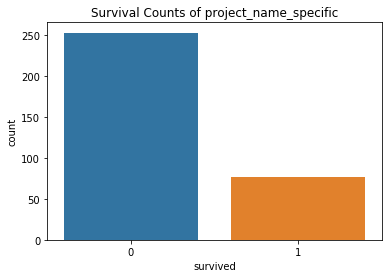

In [11]:
#Visualize the survival ratio
plt.title('Survival Counts of project_name_specific')
sns.countplot(project_df['survived'],label='Count')

['Project_Active_Discretionary_Flag', 'Project_Category', 'Project_Client_VC_Area', 'Project_Date_Created', 'Project_Description', 'Project_End_Date_Actual', 'Project_End_Date_Estimated', 'Project_Executive_Update', 'Project_Funding_Category', 'Project_Go_Live_Estimate', 'Project_Governance_Committee', 'Project_Health', 'Project_ID', 'Project_ITS_Group', 'Project_Jira_Link_to_ITS_Portfolio', 'Project_Jira_Link_to_ITS_PRO_Project', 'Project_Link_to_Charter', 'Project_Long_Name', 'Project_Manager_First_Name', 'Project_Manager_Full_Name', 'Project_Manager_ID', 'Project_Manager_Last_Name', 'Project_Notes', 'Project_Object_List_Complete', 'Project_Object_List_Complete_Date', 'Project_Object_List_Complete_Percent', 'Project_Priority_Score', 'Project_Senior_Manager_First_Name', 'Project_Senior_Manager_Full_Name', 'Project_Senior_Manager_ID', 'Project_Senior_Manager_Last_Name', 'Project_Senior_Manager_Unit_Name', 'Project_Short_Name', 'Project_Start_Date_Actual', 'Project_Start_Date_Estimated'

/Users/l9mendoza/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/l9mendoza/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
/Users/l9mendoza/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


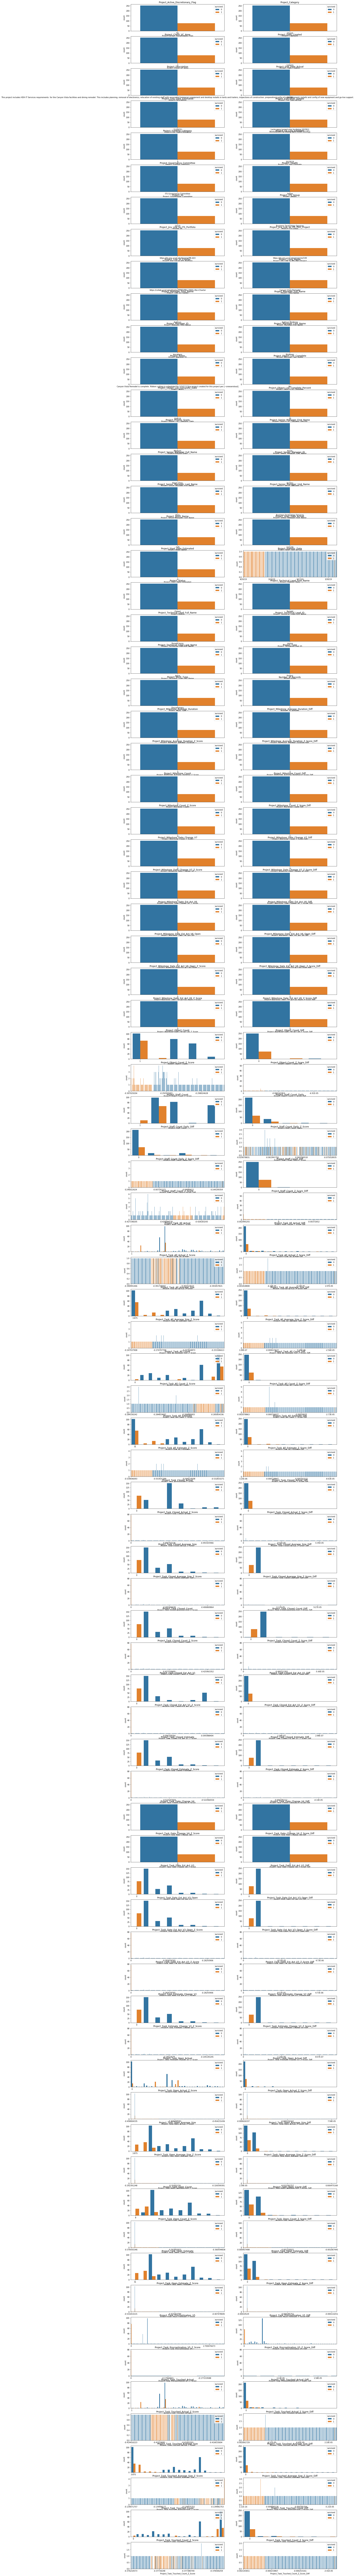

In [12]:
# Visualize the count of survivors (survived projects) over all columns
cols = list(project_df.columns) 
print(cols)

n_rows = 80
n_cols = 2

# The subplot grid and the figure size of each graph
# This returns a Figure (fig) and an Axes Object (axs)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*10,n_rows*3.2))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        
        i = r*n_cols+ c #index to go through the number of columns       
        ax = axs[r][c] #Show where to position each subplot
        sns.countplot(project_df[cols[i]], hue=project_df['survived'], ax=ax)
        ax.set_xticks(ax.get_xticks()[::100])
        ax.set_title(cols[i])
        ax.legend(title='survived', loc='upper right') 
        
plt.tight_layout()   #tight_layout - prevents overlapping
plt.savefig('feature_figs.png')

### After visualizing all possible features, we narrowed the features we are interested in down to;
* 'Project_Milestone_Count': observed higher amount survival at lower project milestone count
* 'Project_Object_Count': observed higher amount survival at lower project object count
* 'Project_Staff_Count': observed higher amount survival at lower project staff count
* 'Project_Task_All_Average_Size': observed higher amount survival at lower project avg task size, some sweet spots
* 'Project_Task_Date_Est_Act_V3': observed survival at lower V3

### Let's visualize these trends throughout different projects 

In [13]:
#create df with only project_to_viz data, change dtypes to numeric/datetime and decribe
project_to_viz_df = main_df[main_df.Project_Long_Name == project_to_viz]
project_to_viz_df = project_to_viz_df[['Project_Milestone_Count','Project_Object_Count','Project_Staff_Count','Project_Statistic_Date', 'Project_Task_All_Average_Size','Project_Task_Date_Est_Act_V3']].copy()
project_to_viz_df[['Project_Milestone_Count','Project_Object_Count', 'Project_Staff_Count','Project_Task_All_Average_Size','Project_Task_Date_Est_Act_V3']] = project_to_viz_df[['Project_Milestone_Count','Project_Object_Count', 'Project_Staff_Count','Project_Task_All_Average_Size','Project_Task_Date_Est_Act_V3']].apply(pd.to_numeric)
project_to_viz_df[['Project_Statistic_Date']].apply(pd.to_datetime)
project_to_viz_df = project_to_viz_df.fillna(0)

project_to_viz_df.describe()

,Project_Milestone_Count,Project_Object_Count,Project_Staff_Count,Project_Task_All_Average_Size,Project_Task_Date_Est_Act_V3
count,330.0,330.000000,330.000000,330.000000,330.000000
mean,0.0,1.848485,2.860606,7.759177,2573.473296
std,0.0,1.157011,1.212383,4.470847,1593.218824
min,0.0,0.000000,1.000000,0.000000,0.000000
25%,0.0,1.000000,2.000000,3.875000,1833.200000
50%,0.0,1.000000,2.000000,3.875000,3288.700000
75%,0.0,2.000000,3.000000,12.263158,3914.875000
max,0.0,4.000000,5.000000,14.166667,3914.875000


In [14]:
# Apply label_survived fxn and save results in new column
project_to_viz_df['survived'] = project_to_viz_df.apply (lambda row: label_survived(row), axis=1)

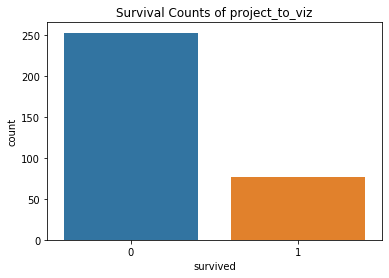

In [15]:
#Visualize the count of number of survivors
plt.title('Survival Counts of project_to_viz')
sns.countplot(project_to_viz_df['survived'],label='Count')

['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3', 'Project_Statistic_Date']


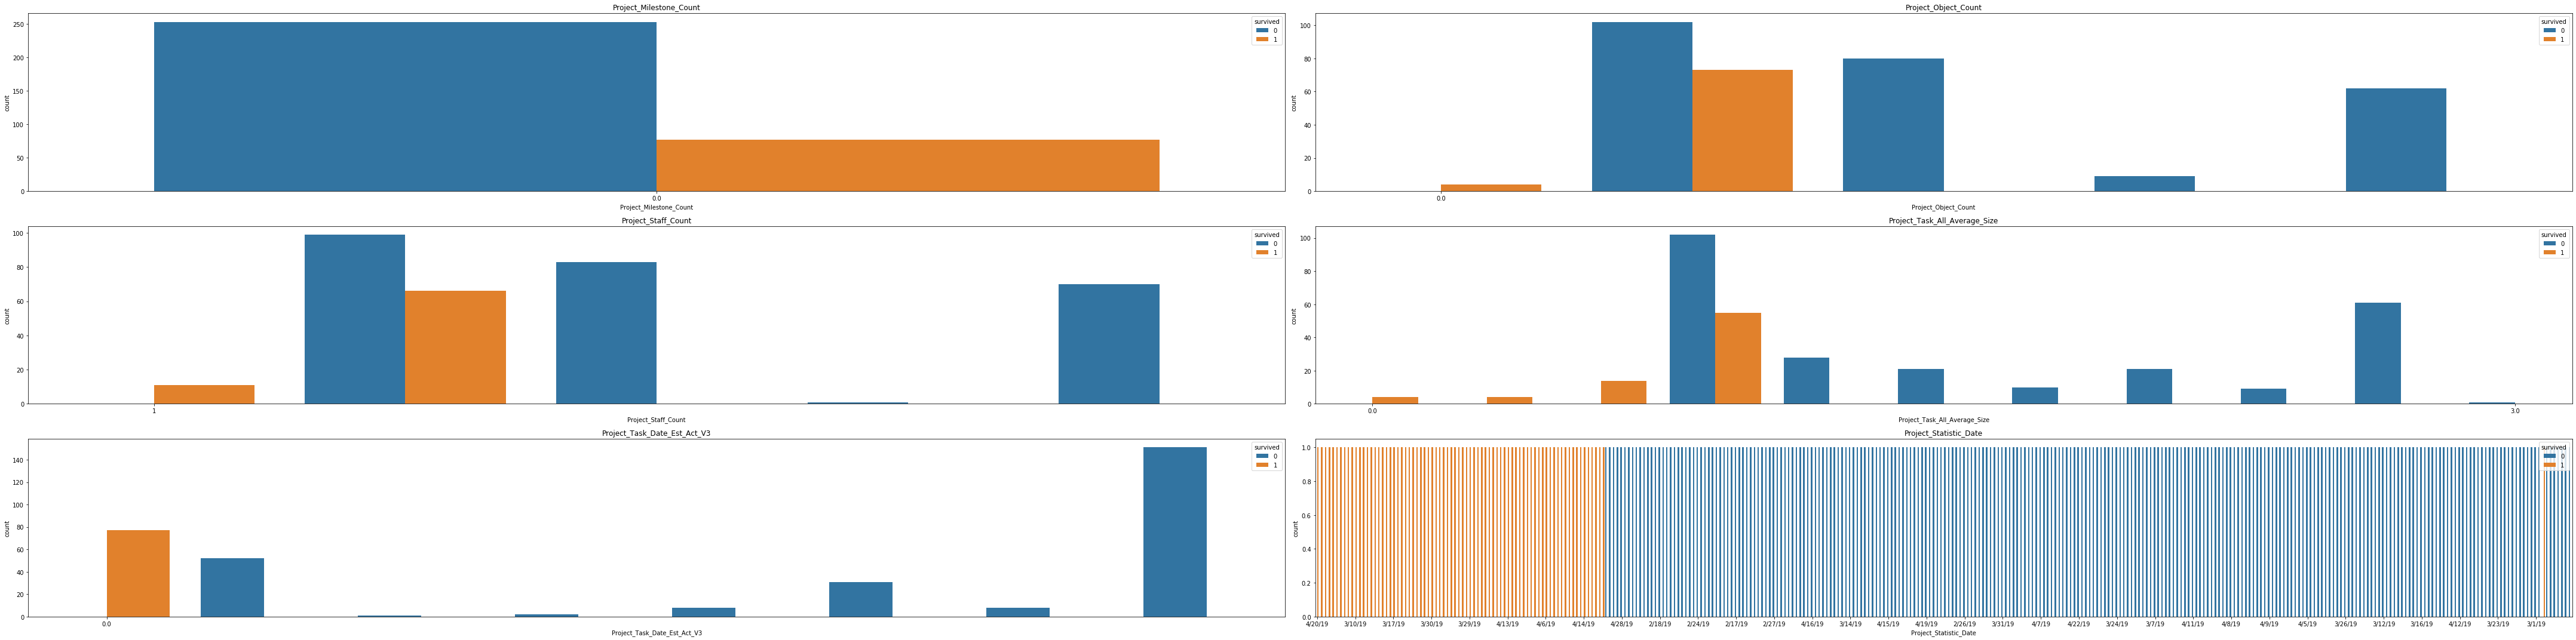

In [16]:
'''
Visualize the count of survivors for columns 'Project_Milestone_Count', 'Project_Object_Count',
'Project_Staff_Count', 'Project_Task_All_Average_Size','Project_Task_Date_Est_Act_V3', 'Project_Statistic_Date'
'''
cols = ['Project_Milestone_Count', 'Project_Object_Count','Project_Staff_Count', 'Project_Task_All_Average_Size',
        'Project_Task_Date_Est_Act_V3', 'Project_Statistic_Date']
print(cols)

n_rows = 3
n_cols = 2

# The subplot grid and the figure size of each graph
# This returns a Figure (fig) and an Axes Object (axs)
#fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.2,n_rows*3.2))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*30,n_rows*5))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        
        i = r*n_cols+ c #index to go through the number of columns       
        ax = axs[r][c] #Show where to position each subplot
        sns.countplot(project_to_viz_df[cols[i]], hue=project_to_viz_df['survived'], ax=ax)
        ax.set_xticks(ax.get_xticks()[::10])
        ax.set_title(cols[i])
        ax.legend(title='survived', loc='upper right') 
        
        
        
plt.tight_layout()   #tight_layout - prevents overlapping
plt.savefig('project_to_viz_feature_figs.png')

## 2. Preprocessing: Clean date for input into machine learning models to predict “survival”  (V3 score <= 25, or project actual end date +/- 5 days behind/early)
* Combine all projects and create df to run through ML Models


In [17]:
# Prepare dataset for model input
print('Before dropping null values in feature columns in main_df: ', main_df.shape)
main_df = main_df.dropna(subset=['Project_Long_Name','Project_Statistic_Date','Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3'])
print('After dropping null values in feature columns in main_df: ', main_df.shape)

model_df = main_df # option for isolating specific projects ex) model_df = main_df[(main_df.Project_Long_Name == 'XXX')] 

# Feature Isolation: features are predetermined from previous statisical analysis as relevant to survival 
model_df = model_df[['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3']].copy() 
print('After dropping non-feaure columns in model_df: ', model_df.shape)
model_df = model_df.apply(pd.to_numeric) # convert all columns of DataFrame to numerical value
model_df.describe()

Before dropping null values in feature columns in main_df:  (63274, 168)
After dropping null values in feature columns in main_df:  (19264, 168)
After dropping non-feaure columns in model_df:  (19264, 5)


,Project_Milestone_Count,Project_Object_Count,Project_Staff_Count,Project_Task_All_Average_Size,Project_Task_Date_Est_Act_V3
count,19264.000000,19264.000000,19264.000000,19264.000000,1.926400e+04
mean,7.177845,27.603976,16.282963,14.715923,2.525126e+04
std,5.527628,23.470150,19.968579,15.827529,1.079925e+05
min,1.000000,1.000000,1.000000,0.945370,0.000000e+00
25%,2.000000,10.000000,5.000000,6.929040,1.352500e+03
50%,6.000000,18.000000,11.000000,11.762590,2.816385e+03
75%,11.000000,42.000000,17.000000,17.487805,7.637844e+03
max,31.000000,105.000000,141.000000,332.500000,1.037229e+06


In [18]:
# Create separate dataframe to save identifying info: project name at each statisitic date, to be used for merging predictions
id_df = main_df[['Project_Long_Name','Project_Statistic_Date','Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3']].copy()
print('id_df (should be 2 more columns than model_df): ', id_df.shape)

id_df (should be 2 more columns than model_df):  (19264, 7)


0    18862
1      402
Name: survived, dtype: int64


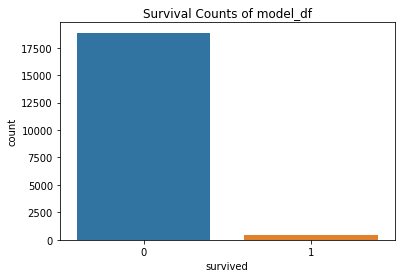

In [19]:
# Apply label survived fxn and ave results in new column
model_df['survived'] = model_df.apply (lambda row: label_survived(row), axis=1)
print(model_df['survived'].value_counts())

#Visualize the count of number of survivors
plt.title('Survival Counts of model_df')
sns.countplot(model_df['survived'],label='Count')

['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3', 'survived']


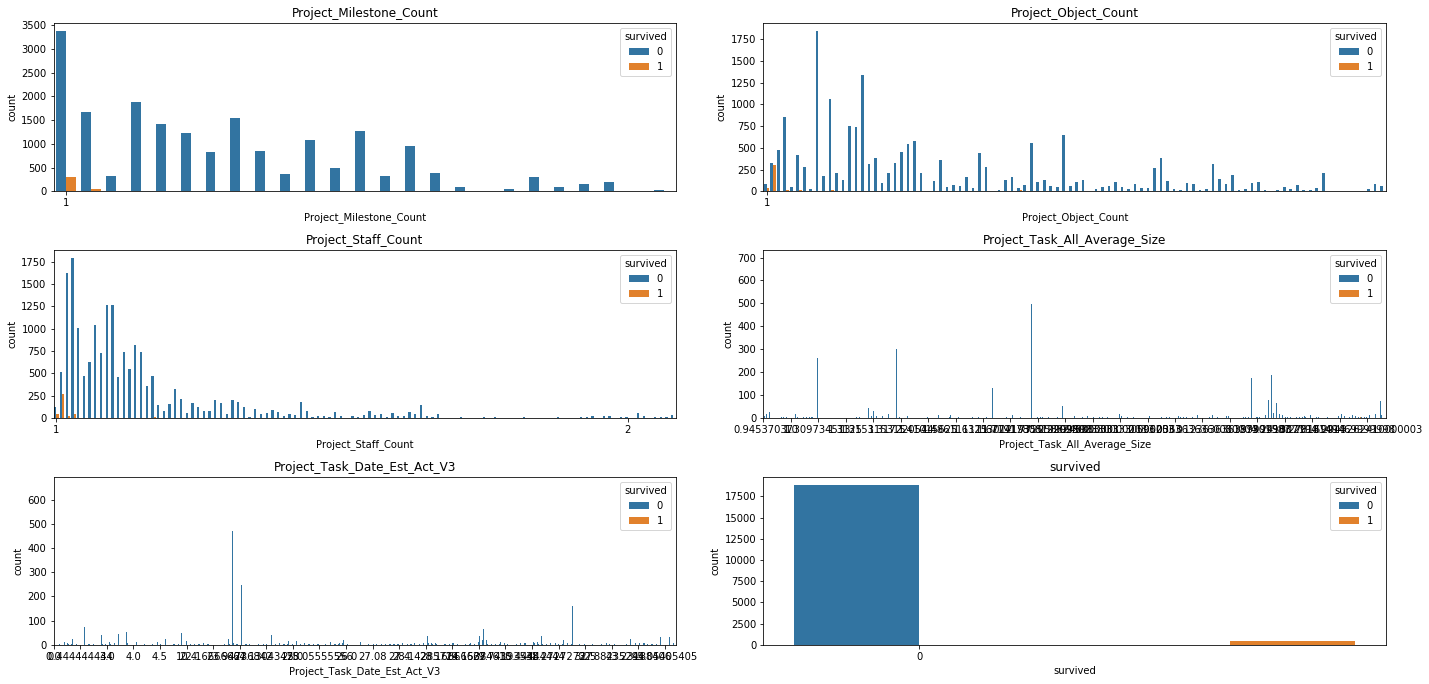

In [20]:
# Visualize the count of survivors for columns 
cols = list(model_df.columns) 
print(cols)

n_rows = 3
n_cols = 2

# The subplot grid and the figure size of each graph
# This returns a Figure (fig) and an Axes Object (axs)
#fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.2,n_rows*3.2))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*10,n_rows*3.2))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        
        i = r*n_cols+ c #index to go through the number of columns       
        ax = axs[r][c] #Show where to position each subplot
        sns.countplot(model_df[cols[i]], hue=model_df["survived"], ax=ax)
        ax.set_xticks(ax.get_xticks()[::100])
        ax.set_title(cols[i])
        ax.legend(title="survived", loc='upper right') 
        
plt.tight_layout()   #tight_layout - prevents overlapping
plt.savefig('model_feature_figs.png')

In [21]:
# Sanity check count of empty (NaN, NAN, na) values in each column 
model_df.isna().sum()

Project_Milestone_Count          0
Project_Object_Count             0
Project_Staff_Count              0
Project_Task_All_Average_Size    0
Project_Task_Date_Est_Act_V3     0
survived                         0
dtype: int64

In [22]:
# Move survived column as first column for input into scikit-learn models
mid = model_df['survived']
model_df.drop(labels=['survived'], axis=1,inplace = True)
model_df.insert(0, 'survived', mid)
list(model_df.columns)

['survived',
 'Project_Milestone_Count',
 'Project_Object_Count',
 'Project_Staff_Count',
 'Project_Task_All_Average_Size',
 'Project_Task_Date_Est_Act_V3']

In [23]:
# Split the data into independent 'X' and dependent 'Y' variables
X = model_df.iloc[:, 1:8].values #features
Y = model_df.iloc[:, 0].values #survived 0/1

In [24]:
# Split the dataset into 80% Training set and 20% Testing set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
original_X_test = X_test # save original values to reference for predictions

In [25]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## 3. Training Model: Run dataset through scikit-learn models, determine accuracy of each model to predict “survival” 
* Features (attributes we have predicted affect the survival outcome): Project Milestone Average Duration,  Project Milestone Count, Project Object Count, Project Staff Count, Project Task All Average Size, Project Statistic Date
* Labels: df[“survived”] = 0 and df[“survived”] = 1  
* Train on skl Logistic Regression, K-nearest neighbor, Linear classifier SVM, RBF classifier SVM, Gaussian Naive Bayes, Decision Tree, Random Forest Classifier Models and evaluate accuracy

In [26]:
#Create a function within many Machine Learning Models
def models(X_train,Y_train):
  
  #Using Logistic Regression Algorithm to the Training Set
  from sklearn.linear_model import LogisticRegression
  log = LogisticRegression(random_state = 0,max_iter = 2000)
  log.fit(X_train, Y_train)
  
  #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
  from sklearn.neighbors import KNeighborsClassifier
  knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
  knn.fit(X_train, Y_train)

  #Using SVC method of svm class to use Support Vector Machine Algorithm
  from sklearn.svm import SVC
  svc_lin = SVC(kernel = 'linear', random_state = 0)
  svc_lin.fit(X_train, Y_train)

  #Using SVC method of svm class to use Kernel SVM Algorithm
  from sklearn.svm import SVC
  svc_rbf = SVC(kernel = 'rbf', random_state = 0)
  svc_rbf.fit(X_train, Y_train)

  #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
  from sklearn.naive_bayes import GaussianNB
  gauss = GaussianNB()
  gauss.fit(X_train, Y_train)

  #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
  from sklearn.tree import DecisionTreeClassifier
  tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
  tree.fit(X_train, Y_train)

  #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
  from sklearn.ensemble import RandomForestClassifier
  forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
  forest.fit(X_train, Y_train)
  
  #print model accuracy on the training data.
  print('[0]Logistic Regression Training Accuracy:', log.score(X_train, Y_train))
  print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_train, Y_train))
  print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train, Y_train))
  print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train, Y_train))
  print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train, Y_train))
  print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_train, Y_train))
  print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_train, Y_train))
  
  return log, knn, svc_lin, svc_rbf, gauss, tree, forest

In [27]:
#Get and train all of the models
model = models(X_train,Y_train)

[0]Logistic Regression Training Accuracy: 0.9813120498345338
[1]K Nearest Neighbor Training Accuracy: 0.9992862241256245
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.9791058334955551
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.9849458179222633
[4]Gaussian Naive Bayes Training Accuracy: 0.9963662319122705
[5]Decision Tree Classifier Training Accuracy: 1.0
[6]Random Forest Classifier Training Accuracy: 1.0


## 4. Testing Models: Predict “survival” using independant test set 

In [28]:
# Save predictions in a dictionary
from sklearn import metrics
log, knn, svc_lin, svc_rbf, gauss, tree, forest = model
ml_models = [log, knn, svc_lin, svc_rbf, gauss, tree, forest]
predictions = {} 
predictions['log'] = (log.predict(X_test), metrics.accuracy_score(Y_test, log.predict(X_test)))
predictions['knn'] = (knn.predict(X_test), metrics.accuracy_score(Y_test, knn.predict(X_test)))
predictions['svc_lin'] = (svc_lin.predict(X_test), metrics.accuracy_score(Y_test, svc_lin.predict(X_test)))
predictions['svc_rbf'] = (svc_rbf.predict(X_test), metrics.accuracy_score(Y_test, svc_rbf.predict(X_test)))
predictions['gauss'] = (gauss.predict(X_test), metrics.accuracy_score(Y_test, gauss.predict(X_test)))
predictions['tree'] = (tree.predict(X_test), metrics.accuracy_score(Y_test, tree.predict(X_test)))
predictions['forest'] = (forest.predict(X_test), metrics.accuracy_score(Y_test, forest.predict(X_test)))

In [29]:
results = pd.DataFrame({'actual': list(Y_test),
                        'log': list(predictions['log'][0]), 
                        'knn': list(predictions['knn'][0]), 
                        'svc_lin': list(predictions['svc_lin'][0]), 
                        'svc_rbf': list(predictions['svc_rbf'][0]), 
                        'gauss': list(predictions['gauss'][0]), 
                        'tree': list(predictions['tree'][0]), 
                        'forest': list(predictions['forest'][0]) }, 
                        columns=['actual','log', 'knn', 'svc_lin', 'svc_rbf', 'gauss', 'tree', 'forest'])
results['Project_Milestone_Count'], results['Project_Object_Count'], results['Project_Staff_Count'], results['Project_Task_All_Average_Size'], results['Project_Task_Date_Est_Act_V3'] = zip(*list(original_X_test))
results

,actual,log,knn,svc_lin,svc_rbf,gauss,tree,forest,Project_Milestone_Count,Project_Object_Count,Project_Staff_Count,Project_Task_All_Average_Size,Project_Task_Date_Est_Act_V3
0,0,0,0,0,0,0,0,0,16.0,25.0,16.0,13.568616,104010.600000
1,0,0,0,0,0,0,0,0,2.0,11.0,2.0,14.062500,5330.000000
2,0,0,0,0,0,0,0,0,13.0,50.0,23.0,12.986842,3596.766082
3,0,0,0,0,0,0,0,0,1.0,4.0,8.0,11.000000,1352.500000
4,0,0,0,0,0,0,0,0,14.0,63.0,25.0,11.657641,1445.873457
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3848,0,0,0,0,0,0,0,0,13.0,62.0,13.0,6.170896,913.832258
3849,0,0,0,0,0,0,0,0,2.0,104.0,10.0,14.936744,68412.686750
3850,0,0,0,0,0,0,0,0,2.0,11.0,4.0,11.670000,56068.777780
3851,0,0,0,0,0,0,0,0,6.0,50.0,6.0,13.453271,4914.359606


In [30]:
#print model accuracy on the testing data.
print('[0]Logistic Regression Training Accuracy:', log.score(X_test, Y_test))
print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_test, Y_test))
print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_test, Y_test))
print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_test, Y_test))
print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_test, Y_test))
print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_test, Y_test))
print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_test, Y_test))

[0]Logistic Regression Training Accuracy: 0.9813132623929406
[1]K Nearest Neighbor Training Accuracy: 0.9979236958214378
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.9792369582143784
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.9857254087723851
[4]Gaussian Naive Bayes Training Accuracy: 0.9945497015312743
[5]Decision Tree Classifier Training Accuracy: 1.0
[6]Random Forest Classifier Training Accuracy: 1.0


In [31]:
id_df[['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3']] = id_df[['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3']].apply(pd.to_numeric)
merged_df = results.merge(id_df, how = 'inner', on = ['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3'])
merged_df = merged_df.drop_duplicates()
#del merged_df['Project_Long_Name'] # for confidentiality
merged_df


,actual,log,knn,svc_lin,svc_rbf,gauss,tree,forest,Project_Milestone_Count,Project_Object_Count,Project_Staff_Count,Project_Task_All_Average_Size,Project_Task_Date_Est_Act_V3,Project_Long_Name,Project_Statistic_Date
0,0,0,0,0,0,0,0,0,16.0,25.0,16.0,13.568616,104010.600000,ESR Academic Personnel Next,3/22/20
1,0,0,0,0,0,0,0,0,16.0,25.0,16.0,13.568616,104010.600000,ESR Academic Personnel Next,3/21/20
2,0,0,0,0,0,0,0,0,16.0,25.0,16.0,13.568616,104010.600000,ESR Academic Personnel Next,4/5/20
3,0,0,0,0,0,0,0,0,16.0,25.0,16.0,13.568616,104010.600000,ESR Academic Personnel Next,3/28/20
4,0,0,0,0,0,0,0,0,16.0,25.0,16.0,13.568616,104010.600000,ESR Academic Personnel Next,3/29/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345158,0,0,0,0,0,0,0,0,9.0,16.0,21.0,56.033784,2366.947368,Two-Step / Duo / MFA,8/29/18
345159,0,0,0,0,0,0,0,0,3.0,18.0,10.0,16.918958,278.666667,EIM - Person Identity (incl COmanage),9/11/19
345160,0,0,0,0,0,0,0,0,3.0,18.0,10.0,16.918958,278.666667,EIM - Person Identity (incl COmanage),9/10/19
345161,0,0,0,0,0,0,0,0,4.0,16.0,9.0,21.402985,4508.941176,UCPath Onboarding,6/4/19


In [32]:
# Save results to CSV for data analysis
merged_df.to_csv('ML_survival_Predictions_Based_On_Completed.csv',index=False)

## 5. Test on Active Projects

In [86]:
#Load the data
active_df = pd.read_csv(proj_stat_detail_view ,dtype=object)
active_df.columns = [c.replace(' ', '_') for c in active_df.columns]

In [87]:
# drop projects that are notactive from main df
print(active_df.shape)    
active_df = active_df[active_df.Project_End_Date_Actual != active_df.Project_End_Date_Actual] # isolate the rows with null
#active_df = active_df[active_df.Project_Active_Discretionary_Flag == 'Yes']
print(active_df.shape)  

(205216, 168)
(141942, 168)


### 5.1 Preprocess active projects

In [88]:
# Prepare dataset for model input
print('Before dropping null values in feature columns in active_df: ', active_df.shape)
active_df = active_df.dropna(subset=['Project_Long_Name','Project_Statistic_Date','Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3'])
print('After dropping null values in feature columns in main_df: ', active_df.shape)

model_df = active_df # option for isolating specific projects ex) model_df = main_df[(main_df.Project_Long_Name == 'XXX')] 

# Feature Isolation: features are predetermined from previous statisical analysis as relevant to survival 
model_df = model_df[['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3']].copy() 
print('After dropping non-feaure columns in model_df: ', model_df.shape)
model_df = model_df.apply(pd.to_numeric) # convert all columns of DataFrame to numerical value
model_df.describe()

Before dropping null values in feature columns in active_df:  (141942, 168)
After dropping null values in feature columns in main_df:  (39689, 168)
After dropping non-feaure columns in model_df:  (39689, 5)


,Project_Milestone_Count,Project_Object_Count,Project_Staff_Count,Project_Task_All_Average_Size,Project_Task_Date_Est_Act_V3
count,39689.000000,39689.000000,39689.000000,39689.000000,39689.000000
mean,11.154426,71.706921,27.749528,13.663309,12407.320861
std,15.063865,187.080495,30.093766,15.076517,38439.341048
min,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,15.000000,9.000000,8.027134,888.532039
50%,7.000000,28.000000,18.000000,11.513158,2792.083333
75%,14.000000,70.000000,36.000000,14.887290,7656.868243
max,108.000000,1730.000000,228.000000,316.391304,467310.388900


In [89]:
# Create separate dataframe to save identifying info: project name at each statisitic date, to be used for merging predictions
id_df = active_df[['Project_Long_Name','Project_Statistic_Date','Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3']].copy()
print('id_df (should be 2 more columns than model_df): ', id_df.shape)

id_df (should be 2 more columns than model_df):  (39689, 7)


0    39346
1      343
Name: survived, dtype: int64


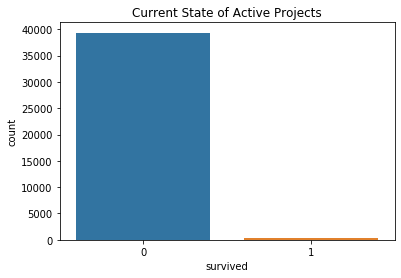

In [90]:
# Apply label survived fxn and ave results in new column
model_df['survived'] = model_df.apply (lambda row: label_survived(row), axis=1)
print(model_df['survived'].value_counts())

#Visualize current state of active projects
plt.title('Current State of Active Projects')
sns.countplot(model_df['survived'],label='Count')

['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3', 'survived']


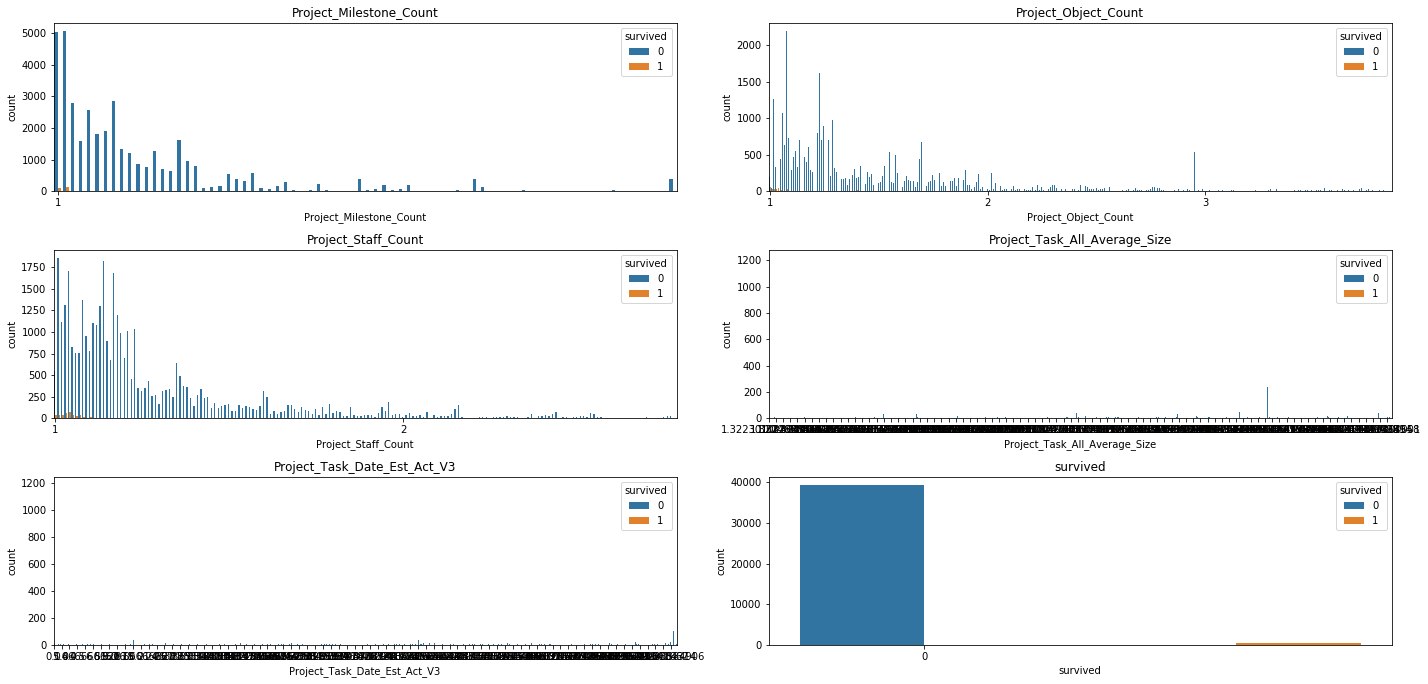

In [91]:
# Visualize state of current projects across all features
cols = list(model_df.columns) 
print(cols)

n_rows = 3
n_cols = 2

# The subplot grid and the figure size of each graph
# This returns a Figure (fig) and an Axes Object (axs)
#fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.2,n_rows*3.2))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*10,n_rows*3.2))

for r in range(0,n_rows):
    for c in range(0,n_cols):  
        
        i = r*n_cols+ c #index to go through the number of columns       
        ax = axs[r][c] #Show where to position each subplot
        sns.countplot(model_df[cols[i]], hue=model_df["survived"], ax=ax)
        ax.set_xticks(ax.get_xticks()[::100])
        ax.set_title(cols[i])
        ax.legend(title="survived", loc='upper right') 
        
plt.tight_layout()   #tight_layout - prevents overlapping
plt.savefig('active_model_feature_figs.png')

In [92]:
# Move survived column as first column for input into scikit-learn models
mid = model_df['survived']
model_df.drop(labels=['survived'], axis=1,inplace = True)
model_df.insert(0, 'survived', mid)
list(model_df.columns)

['survived',
 'Project_Milestone_Count',
 'Project_Object_Count',
 'Project_Staff_Count',
 'Project_Task_All_Average_Size',
 'Project_Task_Date_Est_Act_V3']

In [93]:
# Split the data into independent 'X' and dependent 'Y' variables
X_test = model_df.iloc[:, 1:8].values #features
Y_test = model_df.iloc[:, 0].values # CURRENT V SCORE IS <=25 DOES NOT DENOTE POTENTIAL FOR SURVIVAL !!!
original_X_test = X_test
print(X)

[[1.00000000e+00 2.80000000e+01 3.00000000e+00 8.00000000e+00
  3.13600000e+03]
 [1.00000000e+00 2.80000000e+01 3.00000000e+00 8.00000000e+00
  3.13600000e+03]
 [1.00000000e+00 2.80000000e+01 3.00000000e+00 8.00000000e+00
  3.13600000e+03]
 ...
 [1.00000000e+00 4.00000000e+00 3.00000000e+00 2.74301587e+01
  2.81638461e+03]
 [1.00000000e+00 4.00000000e+00 3.00000000e+00 2.74301587e+01
  2.81638461e+03]
 [1.00000000e+00 4.00000000e+00 3.00000000e+00 1.92787037e+01
  2.81638461e+03]]


In [94]:
print(X_test)
X_test = sc.transform(X_test)
print(X_test)

[[2.00000000e+00 2.00000000e+00 3.00000000e+00 1.80000000e+01
  1.60000000e+01]
 [2.00000000e+00 2.00000000e+00 3.00000000e+00 1.80000000e+01
  1.60000000e+01]
 [2.00000000e+00 2.00000000e+00 3.00000000e+00 1.80000000e+01
  1.60000000e+01]
 ...
 [1.00000000e+00 1.20000000e+01 1.80000000e+01 2.84418605e+01
  7.07816279e+04]
 [1.00000000e+00 1.20000000e+01 1.80000000e+01 2.84418605e+01
  7.07816279e+04]
 [1.00000000e+00 1.20000000e+01 1.80000000e+01 2.84418605e+01
  7.07816279e+04]]
[[-0.94028771 -1.09006225 -0.66708969  0.22075546 -0.23511333]
 [-0.94028771 -1.09006225 -0.66708969  0.22075546 -0.23511333]
 [-0.94028771 -1.09006225 -0.66708969  0.22075546 -0.23511333]
 ...
 [-1.1215062  -0.66625946  0.08675776  0.90282528  0.41880566]
 [-1.1215062  -0.66625946  0.08675776  0.90282528  0.41880566]
 [-1.1215062  -0.66625946  0.08675776  0.90282528  0.41880566]]


### 5.2 Test Active Projects

In [95]:
# Save predictions in a dictionary
predictions = {} 
predictions['log'] = (log.predict(X_test), metrics.accuracy_score(Y_test, log.predict(X_test)))
predictions['knn'] = (knn.predict(X_test), metrics.accuracy_score(Y_test, knn.predict(X_test)))
predictions['svc_lin'] = (svc_lin.predict(X_test), metrics.accuracy_score(Y_test, svc_lin.predict(X_test)))
predictions['svc_rbf'] = (svc_rbf.predict(X_test), metrics.accuracy_score(Y_test, svc_rbf.predict(X_test)))
predictions['gauss'] = (gauss.predict(X_test), metrics.accuracy_score(Y_test, gauss.predict(X_test)))
predictions['tree'] = (tree.predict(X_test), metrics.accuracy_score(Y_test, tree.predict(X_test)))
predictions['forest'] = (forest.predict(X_test), metrics.accuracy_score(Y_test, forest.predict(X_test)))
predictions

{'log': (array(['0', '0', '0', ..., '0', '0', '0'], dtype=object),
  0.9913578069490288),
 'knn': (array(['0', '0', '0', ..., '0', '0', '0'], dtype=object),
  0.9387487716999673),
 'svc_lin': (array(['0', '0', '0', ..., '0', '0', '0'], dtype=object),
  0.9913578069490288),
 'svc_rbf': (array(['0', '0', '0', ..., '0', '0', '0'], dtype=object),
  0.9796921061251228),
 'gauss': (array(['1', '1', '1', ..., '0', '0', '0'], dtype='<U1'),
  0.9960190480989695),
 'tree': (array(['1', '1', '1', ..., '0', '0', '0'], dtype=object), 1.0),
 'forest': (array(['1', '1', '1', ..., '0', '0', '0'], dtype=object),
  0.9998992164075688)}

In [96]:
results = pd.DataFrame({'actual': list(Y_test),
                        'log': list(predictions['log'][0]), 
                        'knn': list(predictions['knn'][0]), 
                        'svc_lin': list(predictions['svc_lin'][0]), 
                        'svc_rbf': list(predictions['svc_rbf'][0]), 
                        'gauss': list(predictions['gauss'][0]), 
                        'tree': list(predictions['tree'][0]), 
                        'forest': list(predictions['forest'][0]) }, 
                        columns=['actual','log', 'knn', 'svc_lin', 'svc_rbf', 'gauss', 'tree', 'forest'])
results['Project_Milestone_Count'], results['Project_Object_Count'], results['Project_Staff_Count'], results['Project_Task_All_Average_Size'], results['Project_Task_Date_Est_Act_V3'] = zip(*list(original_X_test))
results

,actual,log,knn,svc_lin,svc_rbf,gauss,tree,forest,Project_Milestone_Count,Project_Object_Count,Project_Staff_Count,Project_Task_All_Average_Size,Project_Task_Date_Est_Act_V3
0,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000
1,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000
2,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000
3,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000
4,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39684,0,0,0,0,0,0,0,0,1.0,12.0,18.0,28.44186,70781.62791
39685,0,0,0,0,0,0,0,0,1.0,12.0,18.0,28.44186,70781.62791
39686,0,0,0,0,0,0,0,0,1.0,12.0,18.0,28.44186,70781.62791
39687,0,0,0,0,0,0,0,0,1.0,12.0,18.0,28.44186,70781.62791


In [97]:
#print model accuracy on the testing data.
print('[0]Logistic Regression Training Accuracy:', log.score(X_test, Y_test))
print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_test, Y_test))
print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_test, Y_test))
print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_test, Y_test))
print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_test, Y_test))
print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_test, Y_test))
print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_test, Y_test))

[0]Logistic Regression Training Accuracy: 0.9913578069490288
[1]K Nearest Neighbor Training Accuracy: 0.9387487716999673
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.9913578069490288
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.9796921061251228
[4]Gaussian Naive Bayes Training Accuracy: 0.9960190480989695
[5]Decision Tree Classifier Training Accuracy: 1.0
[6]Random Forest Classifier Training Accuracy: 0.9998992164075688


In [98]:
id_df[['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3']] = id_df[['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3']].apply(pd.to_numeric)
merged_df = results.merge(id_df, how = 'inner', on = ['Project_Milestone_Count', 'Project_Object_Count', 'Project_Staff_Count', 'Project_Task_All_Average_Size', 'Project_Task_Date_Est_Act_V3'])
merged_df = merged_df.drop_duplicates()
del merged_df['Project_Long_Name'] # for confidentiality
merged_df

,actual,log,knn,svc_lin,svc_rbf,gauss,tree,forest,Project_Milestone_Count,Project_Object_Count,Project_Staff_Count,Project_Task_All_Average_Size,Project_Task_Date_Est_Act_V3,Project_Statistic_Date
0,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000,3/17/19
1,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000,3/10/19
2,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000,3/13/19
3,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000,3/9/19
4,1,0,0,0,0,1,1,1,2.0,2.0,3.0,18.00000,16.00000,3/6/19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416654,0,0,0,0,0,0,0,0,1.0,12.0,18.0,28.44186,70781.62791,7/2/20
3416655,0,0,0,0,0,0,0,0,1.0,12.0,18.0,28.44186,70781.62791,3/11/20
3416656,0,0,0,0,0,0,0,0,1.0,12.0,18.0,28.44186,70781.62791,6/20/20
3416657,0,0,0,0,0,0,0,0,1.0,12.0,18.0,28.44186,70781.62791,3/16/20


In [99]:
# Save results to CSV for data analysis
merged_df.to_csv('ML_survival_Predictions_Based_On_Active.csv',index=False)

## 6. Single Active Project!
Plug in your own values and see if how each model will predict project survival

In [100]:
#input current project values
proj_milestone_count = 1.0
proj_obj_count = 5.0
proj_staff_count = 7.0
proj_task_avg_size = 13.0
proj_task_data_est_act_v3 = 71.4
proj_long_name = ""
proj_stat_date = ""

# save into np array and transform
new_test = np.array([[proj_milestone_count, proj_obj_count, proj_staff_count, proj_task_avg_size, proj_task_data_est_act_v3]])
print(new_test)
new_test = sc.transform(new_test)
print(new_test)

[[ 1.   5.   7.  13.  71.4]]
[[-1.1215062  -0.96292142 -0.4660637  -0.10584813 -0.2346014 ]]


In [101]:
# Save predictions into dictionary
pred = {}
pred['log'] = log.predict(new_test)
pred['knn'] = knn.predict(new_test)
pred['svc_lin'] = svc_lin.predict(new_test)
pred['svc_rbf'] = svc_rbf.predict(new_test)
pred['gauss'] = gauss.predict(new_test)
pred['tree'] = tree.predict(new_test)
pred['forest'] = log.predict(new_test)

In [102]:
#print predictions
for k, v in pred.items():
    print(k,v)

log ['0']
knn ['0']
svc_lin ['0']
svc_rbf ['0']
gauss ['0']
tree ['0']
forest ['0']
